In [21]:
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import initializers as initializers, regularizers, constraints
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Embedding, Input, Dense, LSTM, GRU, Bidirectional, TimeDistributed
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [23]:

df_review = pd.read_csv('dataset/Reviews.csv')
df_review = df_review[['Score','Text']]
df_review.head()

,Score,Text
0,5,I have bought several of the Vitality canned d...
1,1,Product arrived labeled as Jumbo Salted Peanut...
2,4,This is a confection that has been around a fe...
3,2,If you are looking for the secret ingredient i...
4,5,Great taffy at a great price. There was a wid...


In [73]:
pd.unique(df_review['Score'])

array([5, 1, 4, 2, 3])

In [24]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/dayoung/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dayoung/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/dayoung/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [128]:
# Clean String

from nltk.stem import WordNetLemmatizer
from nltk import tokenize
from nltk.corpus import stopwords

def cleanString(review,stopWords):
    """
    Cleans input string using set rules.
    Cleaning rules:         Every word is lemmatized and lowercased. Stopwords and non alpha-numeric words are removed.
                            Each sentence ends with a period.
    Input:   review       - string(in sentence structure)
             stopWords    - set of strings which should be removed from review
    Output:  returnString - cleaned input string
             idx_list     - list of lists, one list is equal to one sentence. In every list are the index
                            of each word as they appeared in the non cleaned sentence
                            e.g. nonCleaned = "This is a test." -> cleaned = "This test." -> cleaned_index = [[0,3]]
    """
    # Init the Wordnet Lemmatizer
    lemmatizer = WordNetLemmatizer()
    returnString = ""
    sentence_token = tokenize.sent_tokenize(review)
    idx_list = []
    for j in range(len(sentence_token)):
        single_sentence = tokenize.word_tokenize(sentence_token[j])
        sentences_filtered = [(idx,lemmatizer.lemmatize(w.lower())) for idx,w in enumerate(single_sentence) 
                              if w.lower() not in stopWords and w.isalnum()]
        idx_list.append([x[0] for x in sentences_filtered])
        word_list = [x[1] for x in sentences_filtered]
        returnString = returnString + ' '.join(word_list) + ' . '
    
    return returnString, idx_list


cleanString(df_review['Text'][0],['a','the'])[0]
# print(df_review.head())

'i have bought several of vitality canned dog food product and have found them all to be of good quality . product look more like stew than processed meat and it smell better . my labrador is finicky and she appreciates this product better than most . '

In [36]:
## cleanString 한 결과 저장해놓은 것
df_review = pd.read_csv('dataset/df_review.csv')

In [39]:
import string
from tensorflow import keras

# Parameters
MAX_SENTENCE_NUM = 9
MAX_WORD_NUM = 40
MAX_FEATURES = 200000 

# Tokenization
# Word index

"""
Using the keras Tokenizer class a word index is built.
The most 'MAX_FEATURES' used words are tokenized to a number.
this dictionary is saved in word_index
"""
texts = []
for i in range(len(df_review)):
    s = df_review['Text'].iloc[i]
    s = ' '.join([word.strip(string.punctuation) for word in s.split() if word.strip(string.punctuation) is not ""])
    texts.append(s)
tokenizer = keras.preprocessing.text.Tokenizer(num_words=MAX_FEATURES,lower=True, oov_token=None)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index

print('Number of tokens: ' + str(len(word_index)))



<>:20: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:20: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-39-07520ecccf60>:20: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  s = ' '.join([word.strip(string.punctuation) for word in s.split() if word.strip(string.punctuation) is not ""])


Number of tokens: 100040


In [129]:
# df_review['Text']=df_review['Text'].apply(lambda x : cleanString(x,['a','the'])[0])

In [40]:

import numpy as np

"""
A pre-trained word to vector is used from GloVe by Pennington et. al.
Source: https://nlp.stanford.edu/projects/glove/
The data was trained on wikipedia articles. Each word is described by a 100d vector.
"""

# Load word vectors from pre-trained dataset
embeddings_index = {}
f = open(os.path.join(os.getcwd(), 'dataset/glove.6B.100d.txt'), encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# Embedding

EMBED_SIZE = 100

min_wordCount = 2
absent_words = 0
small_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
word_counts = tokenizer.word_counts
for word, i in word_index.items():
    if word_counts[word] > min_wordCount:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
        else:
            absent_words += 1
    else:
        small_words += 1
print('Total absent words are', absent_words, 'which is', "%0.2f" % (absent_words * 100 / len(word_index)),
      '% of total words')
print('Words with '+str(min_wordCount)+' or less mentions', small_words, 'which is', "%0.2f" % (small_words * 100 / len(word_index)),
      '% of total words')
print(str(len(word_index)-small_words-absent_words) + ' words to proceed.')

Found 400000 word vectors.
Total absent words are 13065 which is 13.06 % of total words
Words with 2 or less mentions 52105 which is 52.08 % of total words
34870 words to proceed.


In [41]:
# display(example_df_embedding)
embedding_matrix[word_index['great']]

array([-0.013786  ,  0.38216001,  0.53236002,  0.15261   , -0.29694   ,
       -0.20558   , -0.41846001, -0.58437002, -0.77354997, -0.87866002,
       -0.37858   , -0.18516   , -0.12800001, -0.20584001, -0.22925   ,
       -0.42598999,  0.3725    ,  0.26076999, -1.07019997,  0.62915999,
       -0.091469  ,  0.70348001, -0.4973    , -0.77691001,  0.66044998,
        0.09465   , -0.44893   ,  0.018917  ,  0.33146   , -0.35021999,
       -0.35789001,  0.030313  ,  0.22253001, -0.23236001, -0.19719   ,
       -0.0053125 , -0.25848001,  0.58081001, -0.10705   , -0.17845   ,
       -0.16205999,  0.087086  ,  0.63028997, -0.76648998,  0.51618999,
        0.14072999,  1.01900005, -0.43136001,  0.46138   , -0.43584999,
       -0.47567999,  0.19226   ,  0.36065   ,  0.78987002,  0.088945  ,
       -2.78139997, -0.15366   ,  0.01015   ,  1.17980003,  0.15167999,
       -0.050112  ,  1.26259995, -0.77526999,  0.36030999,  0.95761001,
       -0.11385   ,  0.28035   , -0.02591   ,  0.31246001, -0.15

In [2]:
# df_review.to_csv('dataset/df_review.csv',index=False)
# import tensorflow as tf
# import pandas as pd
# df_review = pd.read_csv('dataset/df_review.csv')

In [ ]:
# MAX_WORD_LENGTH = 7
# MAX_WORDS = 10
# MAX_NB_CHARS = 1000
# EMBEDDING_DIM = 10
# VALIDATION_SPLIT = 0.2

## Parameters
# MAX_SENTENCE_NUM = 9
# MAX_WORD_NUM = 40
# MAX_FEATURES = 200000 

In [49]:
text = df_review['Text']

sentences = text.apply(lambda x: [word.strip(string.punctuation) for word in x.split() if word.strip(string.punctuation) is not ""])


# tokenizer = Tokenizer(num_words=MAX_FEATURES, char_level=True)
# tokenizer.fit_on_texts(sentences.values)


<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-49-f0b0aee0edbb>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  sentences = text.apply(lambda x: [word.strip(string.punctuation) for word in x.split() if word.strip(string.punctuation) is not ""])


In [51]:
data = np.zeros((len(sentences), MAX_SENTENCE_NUM, MAX_WORD_NUM ), dtype='int32')

for i, words in enumerate(sentences):
    for j, word in enumerate(words):
        if j < MAX_SENTENCE_NUM:
            k = 0
            for _, char in enumerate(word):
                try:
                    if k < MAX_WORD_NUM:
                        if tokenizer.word_index[char] < MAX_FEATURES:
                            data[i, j, k] = tokenizer.word_index[char]
                            k=k+1
                except:
                    None

In [52]:
char_index = tokenizer.word_index
print('Total %s unique tokens.' % len(char_index))

labels = pd.get_dummies(df_review['Score']).values
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Total 100040 unique tokens.
Shape of data tensor: (568454, 9, 40)
Shape of label tensor: (568454, 5)


In [53]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(0.1 * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

print('Number of positive and negative reviews in traing and validation set')
print (y_train.sum(axis=0))
print (y_val.sum(axis=0))

Number of positive and negative reviews in traing and validation set
[ 47075  26835  38328  72490 326881]
[ 5193  2934  4312  8165 36241]


In [12]:
# temp = df_review['Text'].apply(lambda x: tokenize.sent_tokenize(x))

In [29]:
# df_review['Text']=temp
# df_review.head()

,Score,Text
0,5,[i have bought several of vitality canned dog ...
1,1,[product arrived labeled a jumbo salted peanut...
2,4,[this is confection that ha been around few ce...
3,2,[if you are looking for secret ingredient in r...
4,5,"[great taffy at great price ., there wa wide a..."


In [33]:
# MAX_FEATURES = 200000 # maximum number of unique words that should be included in the tokenized word index
# MAX_SENTENCE_NUM = 40 # maximum number of sentences in one document
# MAX_WORD_NUM = 50     # maximum number of words in each sentence
# EMBED_SIZE = 100      # vector size of word embedding

MAX_SENTENCE_NUM = 9
MAX_WORD_NUM = 40
MAX_FEATURES = 200000 

In [42]:


def split_df(dataframe, column_name, training_split, validation_split, test_split):
    """
    Splits a pandas dataframe into trainingset, validationset and testset in specified ratio.
    All sets are balanced, which means they have the same ratio for each category as the full set.
    Input:   dataframe        - Pandas Dataframe, should include a column for data and one for categories
             column_name      - Name of dataframe column which contains the categorical output values
             training_split   - from ]0,1[, default = 0.6
             validation_split - from ]0,1[, default = 0.2        
             test_split       - from ]0,1[, default = 0.2
                                Sum of all splits need to be 1
    Output:  train            - Pandas DataFrame of trainset
             validation       - Pandas DataFrame of validationset
             test             - Pandas DataFrame of testset
    """
    if training_split + validation_split + test_split != 1.0:
        raise ValueError('Split paramter sum should be 1.0')
        
    total = len(dataframe.index)
 
    train = dataframe.reset_index().groupby(column_name).apply(lambda x: x.sample(frac=training_split))\
    .reset_index(drop=True).set_index('index')
    train = train.sample(frac=1)
    temp_df = dataframe.drop(train.index)
    validation = temp_df.reset_index().groupby(column_name)\
    .apply(lambda x: x.sample(frac=validation_split/(test_split+validation_split)))\
           .reset_index(drop=True).set_index('index')
    validation = validation.sample(frac=1)
    test = temp_df.drop(validation.index)
    test = test.sample(frac=1)
    
    print('Total: ', len(dataframe))
    print('Training: ', len(train), ', Percentage: ', len(train)/len(dataframe))
    print('Validation: ', len(validation), ', Percentage: ', len(validation)/len(dataframe))
    print('Test:', len(test), ', Percentage: ', len(test)/len(dataframe))

    return train, validation, test

train, validation, test = split_df(df_review, 'Score',0.8,0.1,0.1)



Total:  568454
Training:  454763 , Percentage:  0.7999996481685413
Validation:  56846 , Percentage:  0.10000105549437598
Test: 56845 , Percentage:  0.09999929633708268


In [67]:
# np.array(train['Text'][0])

array(['i have bought several of vitality canned dog food product and have found them all to be of good quality .',
       'product look more like stew than processed meat and it smell better .',
       'my labrador is finicky and she appreciates this product better than most .'],
      dtype='<U105')

In [83]:
# teeeeemp = train['Text'].apply(lambda x: np.array(x))

In [54]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
K = tf.keras.backend
class AttentionLayer(Layer):
    """
    Hierarchial Attention Layer as described by Hierarchical Attention Networks for Document Classification(2016)
    - Yang et. al.
    Source: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
    Theano backend
    """
    def __init__(self,attention_dim=100,return_coefficients=False,**kwargs):
        # Initializer 
        self.supports_masking = True
        self.return_coefficients = return_coefficients
        self.init = initializers.get('glorot_uniform') # initializes values with uniform distribution
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Builds all weights
        # W = Weight matrix, b = bias vector, u = context vector
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)),name='W')
        self.b = K.variable(self.init((self.attention_dim, )),name='b')
        self.u = K.variable(self.init((self.attention_dim, 1)),name='u')
        self._trainable_weights = [self.W, self.b, self.u]

        super(AttentionLayer, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, hit, mask=None):
        # Here, the actual calculation is done
        uit = K.bias_add(K.dot(hit, self.W),self.b)
        uit = K.tanh(uit)
        
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)
        ait = K.exp(ait)
        
        if mask is not None:
            ait *= K.cast(mask, K.floatx())

        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = hit * ait
        
        if self.return_coefficients:
            return [K.sum(weighted_input, axis=1), ait]
        else:
            return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        if self.return_coefficients:
            return [(input_shape[0], input_shape[-1]), (input_shape[0], input_shape[-1], 1)]
        else:
            return input_shape[0], input_shape[-1]


In [96]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import initializers
"""
Create Keras functional model for hierarchical attention network
"""
# original embedding layer
# embedding_layer = Embedding(len(word_index) + 1,EMBED_SIZE,weights=[embedding_matrix], 
#                             input_length=MAX_WORD_NUM, trainable=False,name='word_embedding')
tf.compat.v1.disable_eager_execution()
with tf.device("/gpu:0"):
    embedding_layer = Embedding(len(char_index) + 1,
                                EMBED_SIZE,#10
                                weights=[embedding_matrix],
                                input_length=MAX_WORD_NUM,
                                trainable=True,
                               name='word_embedding')
    # Words level attention model
    word_input = Input(shape=(MAX_WORD_NUM,), dtype='int32',name='word_input')
    word_sequences = embedding_layer(word_input)
    word_gru = Bidirectional(GRU(50, return_sequences=True),name='word_gru')(word_sequences)
    word_dense = Dense(100, activation='relu', name='word_dense')(word_gru) 
    word_att,word_coeffs = AttentionLayer(EMBED_SIZE,True,name='word_attention')(word_dense)
    wordEncoder = Model(inputs = word_input,outputs = word_att)

    # Sentence level attention model
    sent_input = Input(shape=(MAX_SENTENCE_NUM,MAX_WORD_NUM), dtype='int32',name='sent_input')
    sent_encoder = TimeDistributed(wordEncoder,name='sent_linking')(sent_input)
    sent_gru = Bidirectional(GRU(50, return_sequences=True),name='sent_gru')(sent_encoder)
    sent_dense = Dense(100, activation='relu', name='sent_dense')(sent_gru) 
    sent_att,sent_coeffs = AttentionLayer(EMBED_SIZE,return_coefficients=True,name='sent_attention')(sent_dense)
    sent_drop = Dropout(0.5,name='sent_dropout')(sent_att)
    preds = Dense(5, activation='softmax',name='output')(sent_drop)

    # Model compile
    model = Model(sent_input, preds)
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
    print(wordEncoder.summary())
    print(model.summary())

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_input (InputLayer)      [(None, 40)]              0         
_________________________________________________________________
word_embedding (Embedding)   (None, 40, 100)           10004100  
_________________________________________________________________
word_gru (Bidirectional)     (None, 40, 100)           45600     
_________________________________________________________________
word_dense (Dense)           (None, 40, 100)           10100     
_________________________________________________________________
word_attention (AttentionLay [(None, 100), (None, 40,  10200     
Total params: 10,070,000
Trainable params: 10,070,000
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_8"
_________________________________________________________________
Layer (type)             

In [87]:
# y_train = train['Score']
# # x_train = train['Text']
# x_train = teeeeemp
# y_val = validation['Score']
# x_val = validation['Text']
# y_test = test['Score']
# x_test = test['Text']

In [88]:
# x_train.shape
# y_train = to_categorical(np.asarray(y_train))

In [31]:

# sequences = tokenizer.texts_to_sequences(x_train)
# x_train = pad_sequences(sequences, maxlen=MAX_WORD_NUM)
# sequences = tokenizer.texts_to_sequences(x_test)
# x_test = pad_sequences(sequences, maxlen=MAX_WORD_NUM)
# sequences = tokenizer.texts_to_sequences(x_val)
# x_val = pad_sequences(sequences, maxlen=MAX_WORD_NUM)

# y_train = to_categorical(np.asarray(y_train))
# y_val = to_categorical(np.asarray(y_val))
# y_test = to_categorical(np.asarray(y_test))
# sequences = tokenizer.texts_to_sequences(x_val)


In [ ]:
# x_train = data[:-nb_validation_samples]
# y_train = labels[:-nb_validation_samples]
# x_val = data[-nb_validation_samples:]
# y_val = labels[-nb_validation_samples:]

In [ ]:

history = model.fit(x_train, y_train, epochs=1, batch_size=32)


Train on 511609 samples
391392/511609 [=====================>........] - ETA: 14:17 - loss: 1.0528 - acc: 0.6452

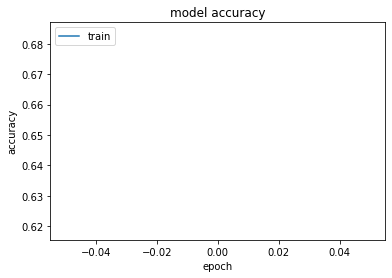

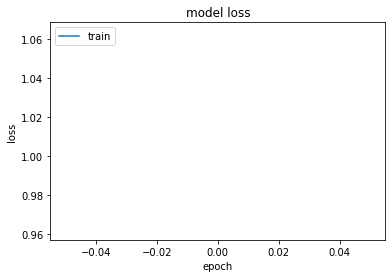

In [60]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [62]:
model.evaluate(x=x_val, y=y_val, batch_size=None, verbose=1, sample_weight=None, steps=None)

 134/1777 [=>............................] - ETA: 1:26 - loss: 1.0037 - acc: 0.6455

KeyboardInterrupt: 

In [ ]:
# Clean article with pre described rules
article_cleaned,idx_list = cleanString(article,stopWords)
input_array = wordToSeq(article_cleaned,word_index,MAX_SENTENCE_NUM,MAX_WORD_NUM,MAX_FEATURES)

In [ ]:
sent_att_weights = Model(inputs=sent_input,outputs=sent_coeffs)
output_array = sent_att_weights.predict(np.resize(input_array,(1,MAX_SENTENCE_NUM,MAX_WORD_NUM)))

# Get n sentences with most attention in document
n_sentences = 5
sent_index = output_array.flatten().argsort()[-n_sentences:]
sent_index = np.sort(sent_index)
sent_index = sent_index.tolist()

# Create summary using n sentences
sent_list = tokenize.sent_tokenize(article)
summary = [sent_list[i] for i in sent_index]

In [64]:
# res = model.predict(np.expand_dims(input_array,axis=0))
res = model.predict(x_val)
res

array([[0.046353  , 0.03741193, 0.06129214, 0.14663391, 0.70830905],
       [0.10746627, 0.08834272, 0.11369296, 0.17507371, 0.5154243 ],
       [0.2514229 , 0.22567882, 0.2718035 , 0.12152804, 0.12956679],
       ...,
       [0.0696284 , 0.0417748 , 0.05960848, 0.13166185, 0.6973265 ],
       [0.12501307, 0.07824251, 0.08861791, 0.14852275, 0.55960375],
       [0.03537109, 0.03469939, 0.06586904, 0.1752103 , 0.6888502 ]],
      dtype=float32)

In [89]:
y_pred=pd.Series(map(np.argmax,res))
y_true = pd.Series(map(np.argmax,y_val))

In [91]:
sum(y_pred == y_true)/len(y_pred)

0.6578942739027179

In [86]:
pd.concat([pd.Series(y_pred),pd.Series(y_true)],axis=1)

,0,1
0,4,4
1,4,1
2,2,1
3,4,4
4,4,4
...,...,...
56840,4,3
56841,0,2
56842,4,0
56843,4,4
